In [84]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

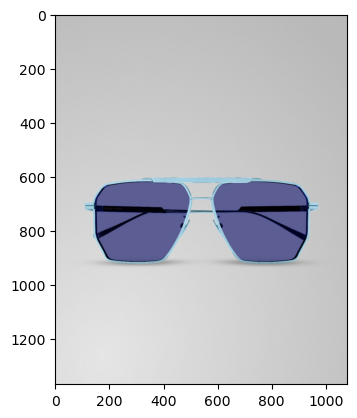

In [85]:
def process(path):

    # load image
    img = cv2.imread(path)

    # convert to gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # threshold input image as mask
    mask = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY)[1]
    mask = 255 - mask

    # clean up mask
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # anti-alias mask
    mask = cv2.GaussianBlur(mask, (0, 0), sigmaX=2, sigmaY=2)
    mask = (2 * mask.astype(np.float32) - 255).clip(0, 255).astype(np.uint8)

    # put alpha into image
    result = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
    result[:, :, 3] = mask

    # Load background
    bg_img = cv2.imread('bg.jpg')
    bg_h, bg_w, _ = bg_img.shape

    # Resize full image to fit width
    aspect_ratio = result.shape[1] / result.shape[0]
    resized_w = bg_w
    resized_h = int(resized_w / aspect_ratio)
    result_resized = cv2.resize(result, (resized_w, resized_h))

    # Bounding box from alpha
    non_zero = cv2.findNonZero(result_resized[:, :, 3])
    x, y, w, h = cv2.boundingRect(non_zero)

    # Crop object from result_resized
    object_crop = result_resized[y:y + h, x:x + w]
    pad = int(bg_w * 0.1)
    usable_w = bg_w - 2 * pad
    obj_ar = w / h
    obj_new_w = usable_w
    obj_new_h = int(obj_new_w / obj_ar)
    fg_resized = cv2.resize(object_crop, (obj_new_w, obj_new_h))

    # Place position
    center_x = pad + (usable_w - obj_new_w) // 2
    center_y = int((bg_h - obj_new_h) / 2 + bg_h / 17)

    # Start composite
    bg_img = bg_img.astype(np.float32)
    roi = bg_img[center_y:center_y + obj_new_h, center_x:center_x + obj_new_w].copy()
    fg_float = fg_resized.astype(np.float32)
    alpha = fg_float[:, :, 3] / 255.0
    alpha_3 = cv2.cvtColor(alpha, cv2.COLOR_GRAY2BGR)
    blended_fg = roi * (1 - alpha_3) + fg_float[:, :, :3] * alpha_3

    # Shadow generation from full image to avoid cutoff
    shadow_mask = result_resized[:, :, 3]
    erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (int(resized_h / 5), int(resized_h / 5)))
    shadow_mask = cv2.erode(shadow_mask, erode_kernel)
    shadow_mask = cv2.GaussianBlur(shadow_mask, (0, 0), sigmaX=resized_h / 10, sigmaY=resized_h / 10)


    # Calculate scaled Y offset
    scale_factor = obj_new_w / w
    scaled_bbox_h = int(h * scale_factor)
    y_offset = int((resized_h - h) / 2 * scale_factor)
    w_offset = int((resized_w - w) / 2 * scale_factor)

    shadow_new_w = bg_w - 2 * (pad - w_offset)

    # Resize shadow width
    shadow_height = 50
    shadow_mask_resized = cv2.resize(shadow_mask, (shadow_new_w, shadow_height))

    # Calculate Y offset between result_resized and fg_resized
    fg_bbox_in_resized = [x, y, w, h]
    scaled_bbox_w = obj_new_w
    scale_factor = scaled_bbox_w / w
    scaled_bbox_h = int(h * scale_factor)
    y_offset = int((resized_h - h) / 2 * scale_factor)

    print(y_offset)

    shadow_top = int(center_y + scaled_bbox_h - ((shadow_height / 5) + shadow_height * (y_offset/fg_h)))
    shadow_left = pad + (usable_w - shadow_new_w) // 2

    print(shadow_top)
    print(shadow_left)

    # Place shadow
    shadow_full_mask = np.zeros((bg_h, bg_w), dtype=np.uint8)
    if 0 <= shadow_top < bg_h - shadow_height:
        shadow_full_mask[shadow_top:shadow_top + shadow_height, shadow_left:shadow_left + shadow_new_w] = shadow_mask_resized

    # Blend shadow on background
    shadow_alpha = shadow_full_mask.astype(np.float32) / 255.0
    shadow_alpha_3ch = cv2.cvtColor(shadow_alpha, cv2.COLOR_GRAY2BGR)
    shadow_color = (0, 0, 0)
    shadow_opacity = 0.4
    shadow_layer = np.full_like(bg_img, shadow_color, dtype=np.float32)
    bg_img = bg_img * (1 - shadow_alpha_3ch * shadow_opacity) + shadow_layer * shadow_alpha_3ch * shadow_opacity

    # Blend foreground again
    bg_roi = bg_img[center_y:center_y + obj_new_h, center_x:center_x + obj_new_w]
    fg_over_bg = blended_fg
    bg_img[center_y:center_y + obj_new_h, center_x:center_x + obj_new_w] = (
        bg_img[center_y:center_y + obj_new_h, center_x:center_x + obj_new_w] * (1 - alpha_3) +
        fg_float[:, :, :3] * alpha_3
    )
    # Darken under shadow
    shadow_fg = shadow_alpha[center_y:center_y + obj_new_h, center_x:center_x + obj_new_w] * 0.25
    darken_mask = (shadow_fg * alpha).astype(np.float32)
    darken_mask_3ch = cv2.cvtColor(darken_mask, cv2.COLOR_GRAY2BGR)
    darkness_strength = 0.8
    fg_rgb = fg_float[:, :, :3]
    fg_rgb_darkened = fg_rgb * (1 - darken_mask_3ch * darkness_strength)
    fg_float[:, :, :3] = fg_rgb_darkened
    fg_over_bg = bg_roi * (1 - alpha_3) + fg_float[:, :, :3] * alpha_3
    bg_img[center_y:center_y + obj_new_h, center_x:center_x + obj_new_w] = fg_over_bg

    final_img = bg_img.astype(np.uint8)

    # Get relative path from ./images
    rel_path = os.path.relpath(path, "./images")

    # Change extension to .webp
    rel_path_no_ext = os.path.splitext(rel_path)[0]
    output_file_path = os.path.join("output", rel_path_no_ext + ".webp")

    # Ensure output directory exists
    output_dir = os.path.dirname(output_file_path)
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)


    print(output_file_path)



    cv2.imwrite(output_file_path, final_img, [cv2.IMWRITE_WEBP_QUALITY, 95])
    final_img.shape

plt.imshow(final_img)
plt.show()


In [86]:

def get_all_jpg_files(root_dir):
    jpg_files = []
    for dirpath, _, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.lower().endswith(".jpg"):
                full_path = os.path.join(dirpath, filename)
                jpg_files.append(full_path)
    return jpg_files



files = get_all_jpg_files("./images")

for file in files:
    process(file)

127
894
2
output\image.webp
82
923
43
output\SS25\BV1032O-009-cat-xxl.webp
93
904
57
output\SS25\BV1126S-005-cat-xxl.webp
93
904
57
output\SS25\BV1126S-006-cat-xxl.webp
93
904
57
output\SS25\BV1126S-007-cat-xxl.webp
89
909
56
output\SS25\BV1190O-007-cat-xxl.webp
89
909
56
output\SS25\BV1190O-008-cat-xxl.webp
89
909
56
output\SS25\BV1190O-009-cat-xxl.webp
81
924
45
output\SS25\BV1212S-008-cat-xxl.webp
81
924
46
output\SS25\BV1212S-009-cat-xxl.webp
85
919
46
output\SS25\BV1215O-008-cat-xxl.webp
62
940
56
output\SS25\BV1228OA-007-cat-xxl.webp
79
920
56
output\SS25\BV1229OA-006-cat-xxl.webp
79
920
56
output\SS25\BV1229OA-007-cat-xxl.webp
75
925
56
output\SS25\BV1241S-005-cat-xxl.webp
75
925
56
output\SS25\BV1241S-006-cat-xxl.webp
72
931
50
output\SS25\BV1242S-005-cat-xxl.webp
81
918
55
output\SS25\BV1263O-005-cat-xxl.webp
81
918
55
output\SS25\BV1263O-006-cat-xxl.webp
74
927
55
output\SS25\BV1266O-005-cat-xxl.webp
74
926
55
output\SS25\BV1266O-006-cat-xxl.webp
61
942
54
output\SS25\BV1273S